In [17]:
# Helper packages
import numpy as np
import pandas as pd
from plotnine import *

# Modeling pre-processing with scikit-learn functionality
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from feature_engine.encoding import RareLabelEncoder  # this might need to be installed use this comand: ! pip install -U feature_engine
from sklearn.feature_selection import VarianceThreshold

# Pickling packages
import pickle

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

In [18]:
# reading the data, the train set and the test set.
cars = pd.read_csv("../EDA/cleaned_data.csv")
cars_Train =  pd.read_csv("../EDA/train.csv")
cars_Test =  pd.read_csv("../EDA/test.csv")

In [19]:
# separate features from labels and only use numeric features
X_train = cars_Train.drop("Price", axis=1)
y_train = cars_Train[["Price"]]

## Target engineering

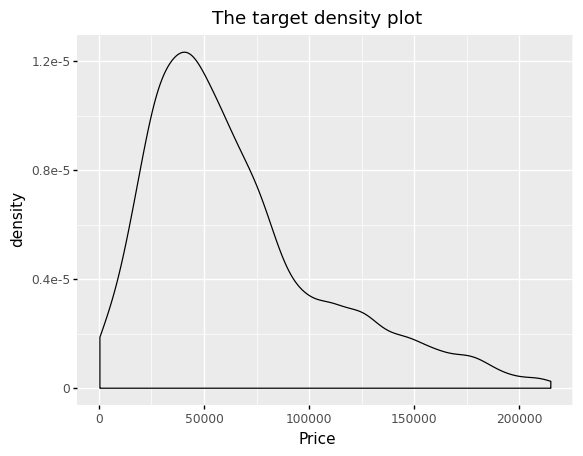

<ggplot: (118229505416)>

In [20]:
# investigating the normality of the target.
(ggplot(cars_Train, aes('Price'))
 + geom_density()
 + ggtitle("The target density plot"))

The target is positively skewed, so it need to be transfirmed.

In [21]:
# creating transformer object
targetTrans = TransformedTargetRegressor(transformer=PowerTransformer(method='box-cox'))
targetTrans

TransformedTargetRegressor(transformer=PowerTransformer(method='box-cox'))

## Dealing With Missing Values

In [22]:
# We already delt wit this issue.
cars.isnull().sum()

Make            0
Type            0
Year            0
Origin          0
Color           0
Options         0
Engine_Size     0
Fuel_Type       0
Gear_Type       0
Mileage         0
Region          0
Price           0
Negotiable      0
Manu_Country    0
dtype: int64

## Features Engineering

In [23]:
# check that numerical features variance is greater than 1
X_train.describe().T["std"] 

Year                4.978301
Engine_Size         1.456385
Mileage        102800.424538
Name: std, dtype: float64

In [24]:
# Normalizing the nimerical features (to deal with skewed distribution)
# Normalizing approach
yj = PowerTransformer(method="yeo-johnson")

# standerizing the nimerical features (to deal with wide range features)
# standerizing approach
scaler = StandardScaler()


### Categorical Features Engineering

In [25]:
# encoding the categoricale features.

# one-hot encoder
encoder = OneHotEncoder()

hot = ColumnTransformer([("one-hot", encoder, selector(dtype_include="object"))])

In [26]:
# Lumping the rare levels together as "Other",
# which is useful since we have features with rare levels such as Make and Type.

# create rare label encoder 
rare_encoder = RareLabelEncoder(tol=0.01, replace_with="other")



we are not going to use principal components analysis because We do not have many numerical features.

## Putting everything togather.

In [27]:
# Creating a preprocessor to use in model_pipline

preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  #("nzv_encode", nzv, selector(dtype_include="number")), # remove lowe variance features
  ("norm", yj, selector(dtype_include="number")),  # normalyze
  ("std", scaler, selector(dtype_include="number")),  # standerize
  #("rare_encode", rare_encoder, selector(dtype_include="object")), # lumping rare levels (if a tree-base model is applyed comment this line)
  ("one-hot", encoder, selector(dtype_include="object")), # encode categorical features
  ])

## you can copy this cell to do the engineering part of your ML


In [28]:
outfile = open("../pickles/features_preprocessor", "wb")
pickle.dump(preprocessor, outfile)
outfile.close()

In [29]:
outfile = open("../pickles/target_transformer", "wb")
pickle.dump(targetTrans, outfile)
outfile.close()

lets try it out

In [ ]:
knn = KNeighborsRegressor()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = KFold(n_splits=10, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {'knn__n_neighbors': range(2, 26)}

model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("knn", knn),
])


# Tune a knn model using grid search
grid_search = GridSearchCV(model_pipeline, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)
## 41915.58187389292